To-do:
1. Текст был очищен только от одного мусорного элемента в качестве примера. Исслудйте данные через ноутбук или чере веб-интерфейс BigQuery на предмет других мусорных элементов в тексте, которые не несут в себе никакого особого смысла, а только создают шум в данных. Доработайте функцию очистки тектосвых данных, чтобы в нее можно было передать список ненужного мусора и разом выполнялась очистка
2. Проведите стратифицировнную кросс-валидуцию нейросетевого классификатора https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html
3. Поэксперементируйте с гиперпараметрами нейросетевого классификатора, постарайтесь повысить качество его работы
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
4. Попробуйте использовать не Word2Vec для получения векторого представления текста, а TF-IDF преобразование http://zabaykin.ru/?p=558 http://nlpx.net/archives/57
5. Попробуйте использовать более тонко настриваемые алгоритмы нейросетей, например из этого видео https://www.youtube.com/watch?v=cPkH1k3U1c8 

In [1]:
import warnings
warnings.filterwarnings('ignore')

from google.oauth2 import service_account
import pandas_gbq 

import numpy as np
import pandas as pd
import math as mt
import datetime as dt

from langdetect import detect
import re

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report,confusion_matrix
from gensim.models.word2vec import Word2Vec
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve,auc,f1_score
import matplotlib.pyplot as plt

import nltk

In [2]:
#funtion for getting fresh data from DWH for workload model
"""[summary]
Funtion for getting fresh data from BigQuery for workload scoring model
[description]
Credentials - google service account object with credentials data for project
[example]
Input: Credentials = credentials_object
Output: description	                                        channel	 category	category_flag
        \nChat transcript:\nVisitor: I want to buy wit...	chat	 ps	        1
        \nChat transcript:\nVisitor: hell i had a prob...	chat	 ps	        1
        \nChat transcript:\nVisitor: لا استطيع الشراء ...	 chat	  ps	     1
"""
def getDwhData(Credentials):
    statement_bigquery_sql = " ".join(["select description, channel, case",
                                       "when manual_category in ('payment_problem','how_to_pay','howtopay','how_to_play','paystation_error','ps_problem','ps_declined') then 'ps'",
                                       "else 'other'",
                                       "end as category,",
                                       "case",
                                       "when manual_category in ('payment_problem','how_to_pay','howtopay','how_to_play','paystation_error','ps_problem','ps_declined') then 0",
                                       "else 1",
                                       "end as category_flag",
                                       "from `xsolla_summer_school.customer_support`",
                                       "where manual_category is not null and",
                                       "manual_category <> '' and",
                                       "description is not null and",
                                       "description <> '' and",
                                       "channel is not null and",
                                       "channel <> '' and",
                                       "channel in ('chat','facebook')"])
    
    dataframe_bigquery = pandas_gbq.read_gbq(statement_bigquery_sql,project_id='findcsystem', credentials=Credentials, dialect='standard')

    return dataframe_bigquery


"""[summary]
Function for transform text to lower case
[description]
Corpus - list or array object, with text data
[example]
Input: Corpus = ["Text_1","Text_2"]
Output: ["text_1","text_2"]
"""
def lowerCase(Corpus):
    corpus = [i.lower().replace('\n',' ') for i in Corpus]
    return corpus


"""[summary]
Function for getting language of text
[description]
Corpus - list or array object, with text data
[example]
Input: Corpus = ["Text_1","Text_2"]
Output: ["en","ru"]
"""
def getTextLanguage(Corpus):
    txt_lang = []
    for txt in Corpus:
        try:
            lang = detect(txt)
            txt_lang.append(lang)
        except:
            lang = 'error'
            txt_lang.append(lang)
    
    return txt_lang


"""[summary]
Function for tokenization text
[description]
Corpus - list or array object, with text data
[example]
Input: Corpus = ["word1 word2","word3 word4"]
Output: [["word1","word2"],["word3","word4"]]
"""  
def textToTokens(Corpus):
    corpus = [i.split() for i in Corpus]
    return corpus 




"""[summary]
Build word vector by using pre-trained Word2Vec model
[description]
Size - lenght of vector
Word2Vec_Model - gensim object
"""  
def buildWordVector(Text,Size,Word2Vec_Model):
    vec = np.zeros(Size).reshape((1,Size))
    count = 0.

    for word in Text:
        try:
            vec += Word2Vec_Model[word].reshape((1,Size))
            count += 1.
        except KeyError:
            continue
    
    if count != 0:
        vec /= count
    
    return vec

RAWDATA 

In [4]:
#getting data from dwh
SupportRawDataframe = getDwhData(CREDENTIALS)
SupportRawDataframe.shape

Downloading: 100%|███████████████████████████████████████████████████████████| 23450/23450 [00:10<00:00, 2223.42rows/s]


(23450, 4)

In [9]:
SupportRawDataframe.head(10)

,description,channel,category,category_flag
0,\nChat transcript:\nVisitor: I want to buy wit...,chat,ps,0
1,\nChat transcript:\nVisitor: hell i had a prob...,chat,ps,0
2,\nChat transcript:\nVisitor: لا استطيع الشراء ...,chat,ps,0
3,\nChat transcript:\nVisitor: im having trouble...,chat,ps,0
4,\nChat transcript:\nVisitor: Hi\nAna: Hello. H...,chat,ps,0
5,\nChat transcript:\nVisitor: Здраствуйте\nAna:...,chat,ps,0
6,\nChat transcript:\nVisitor: hello\nVisitor: w...,chat,ps,0
7,\nChat transcript:\nVisitor: not letting me bu...,chat,ps,0
8,\nChat transcript:\nVisitor: مرحبا\nAna: Hello...,chat,ps,0
9,\nChat transcript:\nVisitor: hi im trying to b...,chat,ps,0


In [7]:
SupportRawDataframe.tail(10)

,description,channel,category,category_flag
23440,"\nChat transcript:\nVisitor: Hello, I bought p...",chat,other,1
23441,\nChat transcript:\nVisitor: Good day\n\nI acc...,facebook,other,1
23442,\nChat transcript:\nVisitor: payment not going...,chat,other,1
23443,\nChat transcript:\nVisitor: Paid for faceit s...,chat,other,1
23444,"\nChat transcript:\nVisitor: Hello, I am tryin...",chat,other,1
23445,"\nChat transcript:\nVisitor: Hi, i made a pruc...",chat,other,1
23446,"\nChat transcript:\nVisitor: Hi, how long will...",chat,other,1
23447,\nChat transcript:\nVisitor: I bought playerun...,chat,other,1
23448,\nChat transcript:\nVisitor: Good day i took t...,chat,other,1
23449,\nChat transcript:\nVisitor: hi\nVisitor: hell...,chat,other,1


DATA PREPROC

In [8]:
#transform text to lower case
corpus = SupportRawDataframe.description
corpus.astype('str')

corpus = lowerCase(corpus)

In [13]:
#getting language for text corpus
corpus_lang = getTextLanguage(corpus)

In [14]:
#new dataframe with texts in lower case, without /n symbol and with lang for text
SupportRawDataframe['description'] = corpus
SupportRawDataframe['lang'] = corpus_lang

In [15]:
SupportRawDataframe.tail(10)

,description,channel,category,category_flag,lang
23440,"chat transcript: visitor: hello, i bought pub...",chat,other,1,en
23441,chat transcript: visitor: good day i acciden...,facebook,other,1,en
23442,chat transcript: visitor: payment not going t...,chat,other,1,en
23443,chat transcript: visitor: paid for faceit sub...,chat,other,1,en
23444,"chat transcript: visitor: hello, i am trying ...",chat,other,1,en
23445,"chat transcript: visitor: hi, i made a prucha...",chat,other,1,en
23446,"chat transcript: visitor: hi, how long will i...",chat,other,1,en
23447,chat transcript: visitor: i bought playerunkn...,chat,other,1,en
23448,chat transcript: visitor: good day i took the...,chat,other,1,en
23449,chat transcript: visitor: hi visitor: hello v...,chat,other,1,en


In [16]:
#getting only en texts
SupportDataframe_eng = SupportRawDataframe[SupportRawDataframe.lang == 'en'][:]
SupportDataframe_eng

,description,channel,category,category_flag,lang
0,chat transcript: visitor: i want to buy with ...,chat,ps,0,en
1,chat transcript: visitor: hell i had a proble...,chat,ps,0,en
2,chat transcript: visitor: لا استطيع الشراء وم...,chat,ps,0,en
3,chat transcript: visitor: im having trouble w...,chat,ps,0,en
4,chat transcript: visitor: hi ana: hello. how ...,chat,ps,0,en
...,...,...,...,...,...
23445,"chat transcript: visitor: hi, i made a prucha...",chat,other,1,en
23446,"chat transcript: visitor: hi, how long will i...",chat,other,1,en
23447,chat transcript: visitor: i bought playerunkn...,chat,other,1,en
23448,chat transcript: visitor: good day i took the...,chat,other,1,en


In [17]:
SupportDataframe_eng.to_csv('SupportDataframe_eng.csv', index=False)

In [3]:
SupportDataframe_eng = pd.read_csv('SupportDataframe_eng.csv')

In [4]:
#токенизируем и убираем все небуквенные токены
def texttoTokenNLTK(descript):
    descript = descript.apply(lambda x: nltk.word_tokenize(x))
    descript = descript.apply(lambda x: [word for word in x if word.isalpha()])
    return descript
    

In [5]:
SupportDataframe_eng.description = texttoTokenNLTK(SupportDataframe_eng.description)

In [6]:
SupportDataframe_eng.head()

,description,channel,category,category_flag,lang
0,"[chat, transcript, visitor, i, want, to, buy, ...",chat,ps,0,en
1,"[chat, transcript, visitor, hell, i, had, a, p...",chat,ps,0,en
2,"[chat, transcript, visitor, لا, استطيع, الشراء...",chat,ps,0,en
3,"[chat, transcript, visitor, im, having, troubl...",chat,ps,0,en
4,"[chat, transcript, visitor, hi, ana, hello, ho...",chat,ps,0,en


In [7]:
#определяем наиболее частоупотребляемые слова в каждой категории
import collections
a = []
b = []
for i in SupportDataframe_eng[SupportDataframe_eng.category_flag==0].description.tolist():
    a += i
for i in SupportDataframe_eng[SupportDataframe_eng.category_flag==1].description.tolist():
    b += i

In [8]:
#считаем их
counts_a = collections.Counter(a)
counts_b = collections.Counter(b)

In [9]:
label_0 = pd.DataFrame(counts_a.most_common(),columns=['words', 'count_0'])
label_1 = pd.DataFrame(counts_b.most_common(),columns=['words', 'count_1'])

In [10]:
label_0.head()

,words,count_0
0,visitor,27245
1,the,21307
2,you,19212
3,i,16866
4,to,16487


In [11]:
label_0.shape

(11544, 2)

In [13]:
label_1.shape

(29325, 2)

In [14]:
#объединяем датасеты для дальнейшей удобной работы
label_merge = pd.merge(label_0, label_1, on='words', how='outer')

Считаем "удельное" количество повторений каждого слова по формуле количество повторов / количество сообщений  
**Важное замечание: Скорее всего, этот не оптимальный метод, так как удельное количество наиболее распространенных слов типа "i, you, ..." в каждом датасете разное. Это может быть вызвано тем, что в одном датасете во время одного обращения общаются дольше, что приводит к увеличению этих слов на одно обращение.**

In [15]:
label_merge.count_0 = label_merge.count_0/11401
label_merge.count_1 = label_merge.count_1/29176

In [17]:
label_merge.head()

,words,count_0,count_1
0,visitor,2.389703,3.852036
1,the,1.868871,2.963703
2,you,1.685115,3.198828
3,i,1.479344,2.665033
4,to,1.446101,2.124623


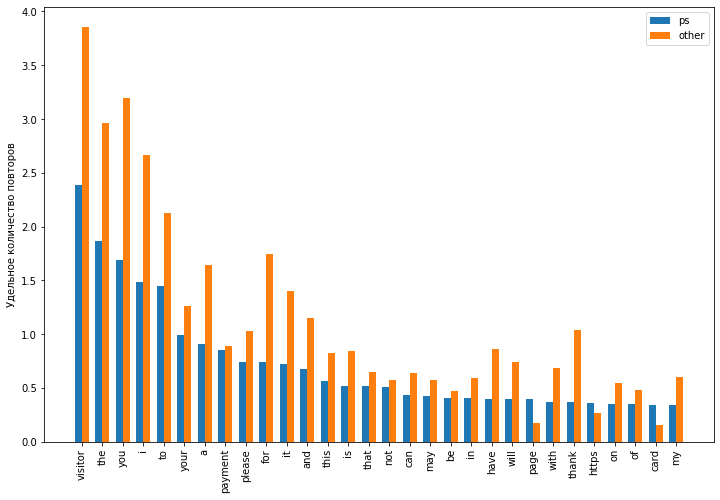

In [83]:
width = 0.35
n = 30
x = np.arange(n)
fig, ax = plt.subplots(figsize=(12, 8))
ax.bar(label_merge.head(n).index - width/2, label_merge.iloc[:,1].head(n), width, label='ps')
ax.bar(label_merge.head(n).index + width/2, label_merge.iloc[:,2].head(n), width, label='other')
ax.set_ylabel('Удельное количество повторов')
ax.set_xticks(x)
ax.set_xticklabels(label_merge.iloc[:,0].head(n))
plt.xticks(rotation=90)
ax.legend()

plt.show()

Найдем отношение повторений между словами в категориях *ps* и *other*. Слова, которые будут встречаться с одной частотой (rate~1) в дальнейшем будем удалять.

In [19]:
label_merge['rate'] = label_merge.count_0 / label_merge.count_1

**Замечание: как оказалось далее, такая мера неверно отображает "одинаковость" использования слов в каждой категории. Пик нормального распределения сильно смещен к нулю, также распределение имеет сильный хвост вправо. К сожалению, времени для исследования новой метрики у меня не осталось, поэтому будем работать с этой метрикой**

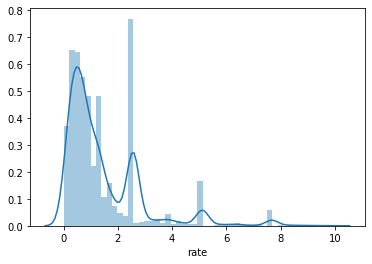

In [103]:
import seaborn as sns
sns.distplot(label_merge['rate'].loc[label_merge.rate < 10].dropna());

In [20]:
#пример
label_merge.loc[label_merge['words'] == 'chat']

,words,count_0,count_1,rate
33,chat,0.29936,0.46857,0.638879


Опишем функцию, которая будет принимать датасет без "стоп"-слов и проводить векторизацию и кросс-валидацию

In [68]:
def Prediction(df):
    unique_categories = np.unique(df.category)
    
    descriptions = df['description']
    categories = df['category_flag']
    XTrain,XTest,YTrain,YTest = train_test_split(descriptions,
                                             categories,
                                             stratify = categories,
                                             test_size = 0.2,
                                             random_state = 40)
    
    NDim = 100
    Imdb_w2v = Word2Vec(size = NDim,min_count = 10)
    
    Imdb_w2v.build_vocab(XTrain)
    
    Imdb_w2v.train(XTrain,total_examples = Imdb_w2v.corpus_count,epochs = Imdb_w2v.epochs)
    TrainVecs = np.concatenate([buildWordVector(i,NDim,Imdb_w2v) for i in XTrain])
    
    Imdb_w2v.train(XTest, total_examples = Imdb_w2v.corpus_count, epochs = Imdb_w2v.epochs)
    TestVecs = np.concatenate([buildWordVector(i,NDim,Imdb_w2v) for i in XTest])
    
    TextClassifier = MLPClassifier(hidden_layer_sizes = (20,10), max_iter = 1000, random_state = 40)
    cv = StratifiedKFold(n_splits=5,random_state=40)
    
    Scores = cross_val_score(TextClassifier, TrainVecs, YTrain, cv = cv)
    print(Scores)
    print(np.mean(Scores))
    
    TextClassifier.fit(TrainVecs,YTrain)
    pred = TextClassifier.predict(TestVecs)
    
    print(classification_report(YTest,pred))
    
    return f1_score(YTest,pred,pos_label=0), f1_score(YTest,pred,pos_label=1)


Ниже через цикл определим как количество слов влияет на f1-score обоих параметров

In [69]:
percent = []
count_word = []
f1_score_0 = []
f1_score_1 = []

for i in np.arange(0, 1, 0.05):
    
    #создаем список "стоп"-слов. i определяет "доля" (сначала я думал, что это будет процент) слов, которые будут удалены.
    words_from_df = list(label_merge.loc[(1-i < label_merge['rate']) & (label_merge['rate'] < 1+i)].words.values)
    
    #на всякий случай добавим список "стоп"-слов из nltk
    stop_words = nltk.corpus.stopwords.words('english')
    stop_words = stop_words + words_from_df
    
    #Записываем "долю" удаленных слов и количество удаленных слов
    percent.append(i)
    count_word.append(len(stop_words))
    
    print(i)
    
    #удаляем из датасета эти слова
    SupportDataframe_eng_sw = SupportDataframe_eng.copy()
    SupportDataframe_eng_sw.description = SupportDataframe_eng_sw.description.apply(lambda x: [w for w in x if not w in stop_words])
    

    #считаем количество оставшихся слов
    a = []
    for i in SupportDataframe_eng_sw.description.tolist():
        a += i
    print(len(collections.Counter(a)))
    
    #по оставшимся словам делаем векторизацию, кроссвалидацию и prediction
    l1, l2 = Prediction(SupportDataframe_eng_sw)
    print(l1, l2)
    
    #фиксируем f1-score для каждой категории
    f1_score_0.append(l1)
    f1_score_1.append(l2)
    
    print('ok')

0.0
33366
[0.91158059 0.9127543  0.9084507  0.9084507  0.91118936]
0.9104851330203443
              precision    recall  f1-score   support

           0       0.47      0.79      0.59       635
           1       0.94      0.78      0.85      2561

    accuracy                           0.78      3196
   macro avg       0.70      0.78      0.72      3196
weighted avg       0.84      0.78      0.80      3196

0.5901833234772325 0.8525845564773451
ok
0.05
33125
[0.90923318 0.90923318 0.89514867 0.89788732 0.91040689]
0.9043818466353677
              precision    recall  f1-score   support

           0       0.60      0.30      0.40       635
           1       0.85      0.95      0.90      2561

    accuracy                           0.82      3196
   macro avg       0.72      0.63      0.65      3196
weighted avg       0.80      0.82      0.80      3196

0.4008394543546695 0.895017466446038
ok
0.1
32968
[0.91197183 0.90219092 0.90101721 0.90571205 0.91236307]
0.9066510172143974
      


0.6889250814332247 0.9260263361735088
ok
0.9
28387
[0.88967136 0.88849765 0.88771518 0.88693271 0.89514867]
0.8895931142410017
              precision    recall  f1-score   support

           0       0.80      0.40      0.54       635
           1       0.87      0.97      0.92      2561

    accuracy                           0.86      3196
   macro avg       0.83      0.69      0.73      3196
weighted avg       0.85      0.86      0.84      3196

0.5370950888192267 0.9184912603495862
ok
0.9500000000000001
28208
[0.87871674 0.87402191 0.87245696 0.87910798 0.89241002]
0.8793427230046948
              precision    recall  f1-score   support

           0       0.79      0.35      0.48       635
           1       0.86      0.98      0.91      2561

    accuracy                           0.85      3196
   macro avg       0.82      0.66      0.70      3196
weighted avg       0.84      0.85      0.83      3196

0.48087431693989074 0.9132736899762643
ok


Построим графики зависимостей f1-score от "доли" удаленных слов и их количества

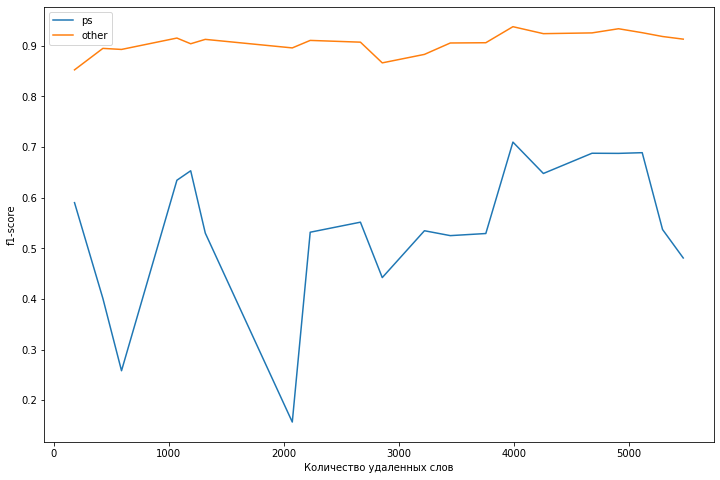

In [105]:
plt.subplots(figsize=(12, 8))
plt.plot(count_word, f1_score_0)
plt.plot(count_word, f1_score_1)
plt.legend(['ps', 'other'])
plt.xlabel('Количество удаленных слов')
plt.ylabel('f1-score')
plt.show()

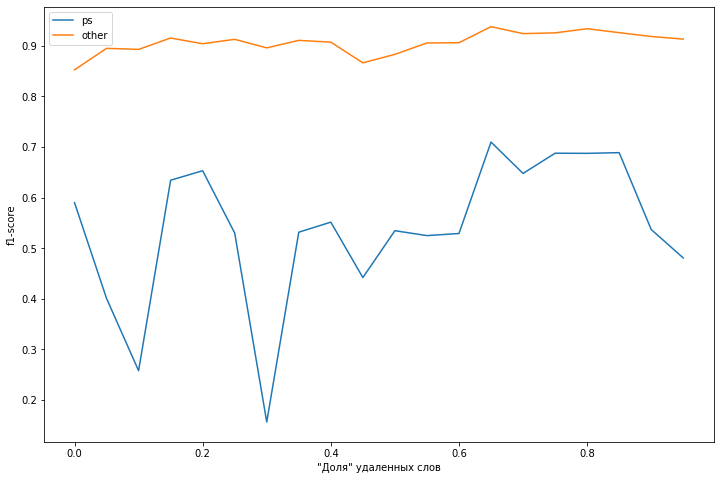

In [106]:
plt.subplots(figsize=(12, 8))
plt.plot(percent, f1_score_0)
plt.plot(percent, f1_score_1)
plt.legend(['ps', 'other'])
plt.xlabel('"Доля" удаленных слов')
plt.ylabel('f1-score')
plt.show()

Максимальный f1-score достигается для 3994 удаленных слов (65% от всех).

Процент удаленных слов 0.65  
29680

cv = 0.9076682316118936  

|          | precision | recall | f1-score | support |
|----------|-----------|--------|----------|---------|
| 0        | 0.81      | 0.63   | 0.71     | 635     |
| 1        | 0.91      | 0.96   | 0.94     | 2561    |
| accuracy |           |        | 0.90     | 3196    |

In [39]:
#baseline
pred = TextClassifier.predict(TestVecs)
print(confusion_matrix(YTest,pred))
print(classification_report(YTest,pred))

[[ 470  166]
 [ 342 2224]]
              precision    recall  f1-score   support

           0       0.58      0.74      0.65       636
           1       0.93      0.87      0.90      2566

    accuracy                           0.84      3202
   macro avg       0.75      0.80      0.77      3202
weighted avg       0.86      0.84      0.85      3202



К сожалению, на остальное время совсем не осталось.